# All in one example

In this example: 

- Drillhole / data preparation
 - we import and clean drillhole database
 - desurvey database
 - export to vtk for visual validation 
- Block model preparation 
 - Fill blocks (entire model)
 - Select blocks below the topo
- Estimation
 - Estimate distance from drillhole 
 - Estimate with ID2 Au grade in blocks (point estimation)

## Drillhole and data preparation

/home/adrian/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')



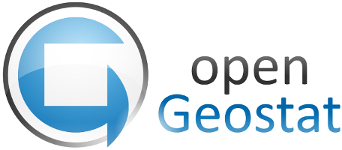

In [1]:
# import required libraries
import pygslib as gslib
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
%matplotlib inline

In [3]:
# import data from file
collar = pd.read_csv('../datasets/dhole_data3/collar.csv')
survey = pd.read_csv('../datasets/dhole_data3/survey.csv')
assay = pd.read_csv('../datasets/dhole_data3/assay.csv')
litho = pd.read_csv('../datasets/dhole_data3/litho.csv')

### Create drillhole object

In [4]:
#create database
mydholedb=gslib.drillhole.Drillhole(collar=collar,survey=survey)
mydholedb.addtable(assay, 'assay' ,overwrite = False)
mydholedb.addtable(litho, 'litho', overwrite = False)

In [5]:
#validate
mydholedb.validate()

/home/adrian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: ! survey with one value at BHID: 10399. This will produce error at desurvey
  from ipykernel import kernelapp as app


In [6]:
# fixing the issue of single interval at survey table
mydholedb.fix_survey_one_interval_err(900.)

In [7]:
#validate table assay
mydholedb.validate_table('assay')

/home/adrian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Info : collar BHID 10398 not at table assay
  from ipykernel import kernelapp as app
/home/adrian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Info : collar BHID 10399 not at table assay
  from ipykernel import kernelapp as app
/home/adrian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Info : collar BHID 11241 not at table assay
  from ipykernel import kernelapp as app
/home/adrian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Info : collar BHID 11242 not at table assay
  from ipykernel import kernelapp as app
/home/adrian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Info : collar BHID 11263 not at table assay
  from ipykernel import kernelapp as app
/home/adrian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Info : collar BHID 11264 not at table ass

In [8]:
#validate table litho
mydholedb.validate_table('litho')


/home/adrian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Info : collar BHID 18843A not at table litho
  from ipykernel import kernelapp as app
/home/adrian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Info : collar BHID CE-5295-7 not at table litho
  from ipykernel import kernelapp as app
/home/adrian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Info : collar BHID G-8 not at table litho
  from ipykernel import kernelapp as app
/home/adrian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Info : collar BHID M-68 not at table litho
  from ipykernel import kernelapp as app
/home/adrian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Info : collar BHID M-69 not at table litho
  from ipykernel import kernelapp as app
/home/adrian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Info : collar BHID M-70 not at table lit

### Merge tables

Merging table will split interval from to tables in order to make FROM-TO equal in each interval. If the two tables have the same field, example ``Au`` and ``Au`` a prefix will be added and the result will have ``Au_A`` and ``Au_B``. In addition a new column with key ``_merge`` will be created to denote what interval are  in both tables, in the left table (A) or in the right table (B)

In [9]:
# first add gaps
gap_assay,overlap_assay = mydholedb.add_gaps(table_name='assay', new_table_name='assay_no_gaps')
gap_litho,overlap_litho = mydholedb.add_gaps(table_name='litho', new_table_name='litho_no_gaps')

# review errors 
print len(gap_assay),len(overlap_assay)
print len(gap_litho),len(overlap_litho)

5043 4
0 0


In [10]:
# see ID of samples with overlaps
print overlap_assay

[4042, 32648, 20514, 20515]


### Merging tables

<div class="alert alert-warning">
    **Warning**: The function merge was designed to work with drillholes without gaps and overlap. Don't use merge without add_gaps first. 
</div>

We will merge assay and litho table in order to be able to do some exploratory analysis. 


In [11]:

mydholedb.merge(table_A = 'assay_no_gaps', table_B = 'litho_no_gaps', new_table_name = 'dhole',
                          overwrite =False, tol=0.01, clean=True)

In [12]:
mydholedb.table['dhole'].head()

,BHID,FROM,TO,_id0,_id1,AU_AVG_GT,LITHO_DESC,lithoID
0,10,0.00000,5.48000,0,0,NaN,Casing,1
1,10,5.48000,25.90000,0,1,NaN,Felsic to Intermediate Dykes,3
2,10,25.90000,27.91968,0,2,NaN,Intermediate to Ultramafic Volcanics,5
3,10,27.91968,29.04444,1,2,0.005,Intermediate to Ultramafic Volcanics,5
4,10,29.04444,30.02280,2,3,0.029,Felsic to Intermediate Dykes,3


### Zero length intervals?

<div class="alert alert-warning">
    **Warning**: Merging produces zero (or almost zero) length intervals.  
</div>


In [13]:
mydholedb.table['dhole'][mydholedb.table['dhole']['TO']-mydholedb.table['dhole']['FROM']<0.01].head()

,BHID,FROM,TO,_id0,_id1,AU_AVG_GT,LITHO_DESC,lithoID
249,10402,110.1840,110.03280,194,72,0.0025,Felsic to Intermediate Dykes,3
255,10402,114.6338,114.60480,200,74,0.0025,Felsic to Intermediate Dykes,3
276,10416,46.9372,46.93920,220,77,0.0430,Intermediate to Ultramafic Volcanics,5
335,10422,70.0996,70.10400,262,97,0.0025,Casing,1
384,10422,367.7982,367.61928,303,109,0.0100,Diorite,2


In [14]:
# remove gaps, this ill include intervals with length < 0.1
gap_assay,overlap_assay = mydholedb.fix_zero_interval(table_name='dhole', 
                                             new_table_name='dholes_no_gaps', 
                                             tol=0.1,
                                             addgaps=True,
                                             overwrite = True)

print len(gap_assay),len(overlap_assay)
print overlap_assay

0 29
[6634, 13778, 732, 1028, 6140, 43189, 8642, 248, 2012, 18642, 39431, 7879, 16781, 42801, 8912, 39526, 1161, 9286, 9238, 35316, 14235, 378, 4292, 4334, 4425, 4451, 4488, 4597, 4635]


### Desurvey

<div class="alert alert-info">
    **Info**: Gaps may be added before desurvey. 
</div>

In [15]:
#desurvey
mydholedb.desurvey('dholes_no_gaps',warns=False, endpoints=True)

### Save results


In [16]:
mydholedb.table['dholes_no_gaps'].to_csv ('../datasets/dhole_data3/dholes_no_gaps.csv')

### Export drillholes to vtk and import in Paraview

In [17]:
mydholedb.export_core_vtk_line('dholes_no_gaps', '../datasets/dhole_data3/dhole.vtk', nanval=0, title = '')

After loading ``dhole.vtk`` in Paraview and changing color scales the result may be like this: 

<img src='figures/dholes_line.png'>

# Block Model

In [18]:
# define block parameters
xorg = 293800
yorg = 5330800
zorg = 160
dx = 80
dy = 40
dz = 80
nx = 18
ny = 18
nz = 1

In [19]:
# Create an empty block model
mymodel=gslib.blockmodel.Blockmodel(nx,ny,nz,xorg,yorg,zorg,dx,dy,dz)

In [20]:
# Creating a full block model with IJK
mymodel.create_IJK(overwrite=True)

In [21]:
# Calculate row, column and level indices from IJK  
mymodel.calc_ixyz_fromijk(overwrite=True)

In [22]:
# Calculate coordinates from indices  
mymodel.calc_xyz_fromixyz(overwrite=True)
print mymodel.bmtable.tail()

     IJK  IX  IY  IZ      XC       YC   ZC
319  319  13  17   0  294880  5331500  200
320  320  14  17   0  294960  5331500  200
321  321  15  17   0  295040  5331500  200
322  322  16  17   0  295120  5331500  200
323  323  17  17   0  295200  5331500  200


In [23]:
# mask points below surface... 

# a) load surface
topo=gslib.vtktools.loadSTL('../datasets/dhole_data2/topo_from_collar.stl')

# get id of blocks centroids below surface (using ray trace)
inside,p=gslib.vtktools.pointquering(topo, 
                                     azm=0, 
                                     dip=90, 
                                     x=mymodel.bmtable.XC.values, 
                                     y=mymodel.bmtable.YC.values, 
                                     z=mymodel.bmtable.ZC.values, 
                                     test=3)



In [24]:
mymodel.bmtable['AIR']= inside

In [25]:
# esport block to VTK for validation
mymodel.blocks2vtkRectilinearGrid('../datasets/dhole_data3/blocks')

In [26]:
#export onli selected blocks
mymodel.bmtable[mymodel.bmtable['AIR']>0].to_csv('../datasets/dhole_data3/blocks_air.csv')

<img src='figures/full-blockm.png'>

## Kriging estimate

In [27]:
# Create a search Neighborhood instance
mymodel.bmtable['meandis']=-10
mysearch=gslib.neighborhood.Neighborhood(mymodel.bmtable['XC'].values,
                      mymodel.bmtable['YC'].values,
                      mymodel.bmtable['ZC'].values,
                      mydholedb.table['dholes_no_gaps']['xm'].values,
                      mydholedb.table['dholes_no_gaps']['ym'].values,
                      mydholedb.table['dholes_no_gaps']['zm'].values,
                      target_properies=mymodel.bmtable['meandis'].values,
                      data_properies=mydholedb.table['dholes_no_gaps']['AU_AVG_GT'].values,
                      angles=[0,0,0],
                      axis=[500,500,500],
                      leafsize=1000000)

### Test apply results

The Neighborhood instance can apply an arbitrary function to each target node in the block. This function can be designed by the user as any thing from mean distance data - block to Kriging, or any advanced Machine Learning algorithm. 

In this example we show how to create an user defined function and apply this function over each block. 

First define a function with the following architecture: 

``` python

def user_function_name(self, <optional> some_parameters ):
    
    #do something here

    return [<list of values>]

```

Then you can apply this function as 

``my_neighborhood.apply_interpolator(interpolator,parameters={},dtypes=[float], scale=1., k=1) ``

where scale and k are the expansion factor of the search ellipse and the number of samples to use. The interpolator is a function object (your user defined function), parameters is a dictionary with the parameters required by your function and dtypes is a list with the right data types of the output of your function. 

<br>

<div class="alert alert-info">
    **Info**: Make sure to include self as argument and to define the output as a list of values with the right dtypes.  
</div>


In [28]:
# we create an interpolation function, in this case the mean distance data-target

def kriging(self, parameters_kt3d, vra, vea, 
            nxdb,nydb,nzdb, 
            xsize, ysize, zsize,
            extest, # external grift at block model
            maxsamp, ran_disc=False):

    #check for nans, not allowed in univariated kriging 
    assert ~np.any(np.isnan(vra)), "Error: NaN values in the data"
    
    n= int(min(maxsamp, len(self.selected_data)))
    
    if n==0:
        return [parameters_kt3d['unest'],
                parameters_kt3d['unest'],
                parameters_kt3d['unest'],
                parameters_kt3d['unest'], 0]  # last index is to show that was not estimated
    
    # get the matrix size 
    mdt, kneq, error = gslib.kt3d_getmatrix_size(ktype,idrif,n)
    
    if error>0:
        print error, n, kneq
        return [parameters_kt3d['unest'],
                parameters_kt3d['unest'],
                parameters_kt3d['unest'],
                parameters_kt3d['unest'], -1]   # last index is to show that was not estimated 
    
    parameters_kt3d['kneq'] = kneq # in SK == n, OK == n+1
    
    
    parameters_kt3d['xa'] = self.data_x[self.selected_data[:n]]
    parameters_kt3d['ya'] = self.data_y[self.selected_data[:n]]
    parameters_kt3d['za'] = self.data_z[self.selected_data[:n]]
    parameters_kt3d['vra'] = vra[self.selected_data[:n]]
    parameters_kt3d['vea'] = vea[self.selected_data[:n]]
    
    # lets calculate cbb
    parameters_blk = { 
                    'xdb'  :  None,  # X coordinates of discretazation points
                    'ydb'  :  None,  # Y coordinates of discretazation points
                    'zdb'  :  None,  # Z coordinates of discretazation points
                    'it'   :  it,   # structure type,  array('i') with bounds (ivarg)        
                    'c0'   :  c0,   # nugget,  array('f') with bounds (ivarg)        
                    'cc'   :  cc,   # variance, array('f') with bounds (nvarg*nst[0])
                    'aa'   :  aa,   # parameter a (or range), array('f') with bounds (nst)
                    'aa1'  :  aa1,   # parameter a (or range), array('f') with bounds (nst)
                    'aa2'  :  aa2,    # parameter a (or range), array('f') with bounds (nst)
                    'ang1'   : ang1,   # input rank-1 array('d') with bounds (nst)
                    'ang2'   : ang2,    # input rank-1 array('d') with bounds (nst)
                    'ang3'   : ang3}     # input rank-1 array('d') with bounds (nst)
    
      
    bx = np.linspace(-xsize/2.+xsize/2./nxdb, xsize/2.-xsize/2./nxdb, nxdb)
    by = np.linspace(-ysize/2.+ysize/2./nydb, ysize/2.-ysize/2./nydb, nydb)
    bz = np.linspace(-zsize/2.+zsize/2./nzdb, zsize/2.-zsize/2./nzdb, nzdb)
    xv, yv, zv = np.meshgrid(bx, by, bz)
    xdb = xv.ravel() 
    ydb = yv.ravel() 
    zdb = zv.ravel() 
    if ran_disc: 
        xdb = xdb + np.random.uniform(-xsize/2./n, xsize/2./n,size=len(xdb))
        ydb = ydb + np.random.uniform(-ysize/2./n, ysize/2./n,size=len(ydb))
        zdb = zdb + np.random.uniform(-zsize/2./n, zsize/2./n,size=len(zdb))
    
    parameters_blk['xdb']=xdb
    parameters_blk['ydb']=ydb
    parameters_blk['zdb']=zdb

    cbb= gslib.block_covariance(parameters_blk)

    parameters_kt3d['xdb']=xdb
    parameters_kt3d['ydb']=ydb
    parameters_kt3d['zdb']=zdb
    parameters_kt3d['cbb']=cbb
 
    parameters_kt3d['extest']= extest[self.current_target] # this is defned in neighborhood
    
    parameters_kt3d['radius']=self.axis_x
    
    est,estv,estt,estvt,w,wt,error,kmatrix,kvector,ksolution = gslib.kt3d(parameters_kt3d)      
    
    if error>0:
        return [parameters_kt3d['unest'],
                parameters_kt3d['unest'],
                parameters_kt3d['unest'],
                parameters_kt3d['unest'], -2]  # last index is to show that was not estimated 
    else:
        return [est,estv,estt,estvt,float(n)]
    
    
    
    

In [29]:
# get data without nans
select = ~np.isnan(mydholedb.table['dholes_no_gaps']['AU_AVG_GT'].values)
x= mydholedb.table['dholes_no_gaps']['xm'].values[select]
y= mydholedb.table['dholes_no_gaps']['ym'].values[select]
z= mydholedb.table['dholes_no_gaps']['zm'].values[select]
Au = mydholedb.table['dholes_no_gaps']['AU_AVG_GT'].values[select]
vea = np.zeros(Au.shape) # a constant external drift


# point kriging... only one point at the cetre of the block
xdb = [0] 
ydb = [0]
zdb = [0]

# variogram (two structures with type it expon -> 3 and sph -> 2)
it =  [3, 2]
c0 =  [0.1] # nuget
cc =  [0.4, 0.5] # variances
aa =  [8, 26]    #ranges
aa1 =  [8, 26]
aa2 =  [8, 16]
ang1 = [0, 0]    # structure rotation
ang2 = [0, 0]
ang3 = [0, 0]

ktype = 1 # 1 OK, 0 SK
skmean =0
unest = -999
idrif = [ 0, 0, 0, 0, 0, 0, 0, 0, 0 ] # the drift terms

radius = mysearch.axis_x

# external drift at blocks
extest = 0

kneq = None

parameters_kt3d = { 
                    'xa'      :  None,    # x coordinates
                    'ya'      :  None,    # y coordinates
                    'za'      :  None,    # z coordinates
                    'vra'     :  None,    # variable, array('f') with bounds (na)
                    'vea'     :  None,    # external drift, array('f') with bounds (na)
                    'xdb'     :  None,        # discretization points x coordinates, array('f') with bounds (ndb), ndb is number of discretization points
                    'ydb'     :  None,        # discretization points y coordinates, array('f') with bounds (ndb)
                    'zdb'     :  None,        # discretization points z coordinates, array('f') with bounds (ndb)
                    'extest'  :  None,          # external drift at target block, 'f' 
                    'cbb'     :  None,          # block covariance , 'f'. Use block_covariance(parameters) to calculate its value
                    'radius'  :  radius,          # search radius, 'f'. Only used to rescale some values
                    'c0'      :  c0,      # nugget,  array('f') with bounds (1)  
                    'it'      :  it,      # structure type,  array('i') with bounds (nst)          
                    'cc'      :  cc, # variance, array('f') with bounds (nst)
                    'aa'      :  aa,     # parameter a (or range mayor), array('f') with bounds (nst)
                    'aa1'     :  aa1,     # parameter a1 (or range semimayor), array('f') with bounds (nst)
                    'aa2'     :  aa2,     # parameter a2 (or range minor), array('f') with bounds (nst)
                    'ang1'    :  ang1,     # rotation angle 1, array('f') with bounds (nst)
                    'ang2'    :  ang2,     # rotation angle 2, array('f') with bounds (nst)
                    'ang3'    :  ang3,     # rotation angle 3, array('f') with bounds (nst)
                    'ktype'   :  ktype,           # kriging type, 'i' (-0=SK,1=OK,2=non-st SK,3=exdrift)
                    'skmean'  :  skmean,          # mean for simple kriging, 'f'
                    'unest'   :  unest,    # value for unestimated, 'f'
                    'idrift'   :  idrif,    # drift terms,  array('i') with bounds (9)     
                                                      # the following drift terms are used
                                                      # x,y,z,xx,yy,zz,xy,xz,zy  
                    'kneq'    :  kneq}                   # number of kriging equations, 'f'

In [30]:
# redefine Neighborhood
mysearch=gslib.neighborhood.Neighborhood(mymodel.bmtable['XC'].values,
                      mymodel.bmtable['YC'].values,
                      mymodel.bmtable['ZC'].values,
                      x,
                      y,
                      z,
                      target_properies=mymodel.bmtable['meandis'].values,
                      data_properies=Au,
                      angles=[0,0,0],
                      axis=[50,50,50],
                      leafsize=1000000)

In [31]:
mymodel.bmtable['extest']=1

# now we test the apply function
a=mysearch.apply_interpolator(kriging, 
                                    parameters={'parameters_kt3d':parameters_kt3d, 
                                                'vra':mydholedb.table['dholes_no_gaps']['AU_AVG_GT'].values[select], 
                                                'vea':np.zeros(len(select)), 
                                                'nxdb':1,
                                                'nydb':1,
                                                'nzdb':1, 
                                                'xsize':20, 
                                                'ysize':20, 
                                                'zsize':20,
                                                'extest':mymodel.bmtable['extest'].values, # external grift at block model
                                                'maxsamp':10, 
                                                'ran_disc':False}, 
                                    dtypes=[float, float, float, float, float], k=100)
#print a[2]

100 1 0
100 1 0
100 1 0


/home/adrian/bitbucket/public/pygslib/pygslib/__init__.py:886: UserWarning: Error > 0, check your parameters
  warnings.warn('Error > 0, check your parameters')


In [32]:
# add results to bmodel
mymodel.bmtable['krig']=a[0]
mymodel.bmtable['krig_var']=a[1]
mymodel.bmtable['estt']= a[2]
mymodel.bmtable['estvt']=a[3]
mymodel.bmtable['nsamp']=a[4]

In [33]:
#export results
mymodel.blocks2vtkRectilinearGrid('../datasets/dhole_data3/blocks')

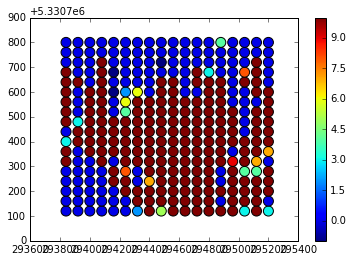

In [34]:
c=plt.scatter(mymodel.bmtable['XC'],mymodel.bmtable['YC'], c=mymodel.bmtable['nsamp'],s=100)
plt.colorbar(c)

This is the result (view as a slice)

** TODO: ** update 

<img src='figures/dist.png'>

This data can be processed in paraview to extract surfaces by distance. The process is simple:

- convert cell data to point data
- do isovolume with 0 < dist < 100
- extract surface
- triangulate (required to export to stl)

This is the output in freecad: 

<img src='figures/surf_100.png'>



This is the output in paraview: 

<img src='figures/surf_100_paraview.png'>
